# GPT-2 Fine-Tuning with PyTorch, Huggingface, Amazon Reviews Dataset




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

This is notebook is mostly from: https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh  

The original author cites these tutorials:  
[Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)  
[Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html)  
[Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them.  
Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

Dataset can be found here:  
[Amazon Reviews 2018 dataset](https://jmcauley.ucsd.edu/data/amazon/) 

In [1]:
import os
import time
import datetime
import json
import math
import torch
import evaluate
import tqdm

import os.path as osp
import pandas as pd
import seaborn as sns
import numpy as np
import random
import pickle

import matplotlib.pyplot as plt
# % matplotlib inline

from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
from tqdm import tqdm
from datetime import datetime, timedelta


torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

# import nltk
# nltk.download('punkt')


from transformers import TrainingArguments, Trainer
from transformers import AutoModelForCausalLM, AutoTokenizer, top_k_top_p_filtering
from torch import nn
from transformers import DataCollatorForLanguageModeling

In [2]:
!nvidia-smi

Sun Jan  1 19:31:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.84       Driver Version: 472.84       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 65%   61C    P8    14W / 184W |   1855MiB / 12288MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [4]:

data_dir = 'D:\Coding\sandbox\Amzn_Stats\Amzn_data'
osp.isdir(data_dir)

dat_files = ['CDs_and_Vinyl_5', 'Prime_Pantry_5', 'Pet_Supplies_5']

# Read Reviews File

with open(osp.join(data_dir, dat_files[0] + '.json'),'r') as f:
    texts = f.readlines()

full_review = [json.loads(txt) for txt in texts]
print(full_review[0])

review_text = []
for fr in tqdm(full_review):
    try:
        review_text.append(fr['reviewText'])
    except:
        pass
print(f'Extracted {len(review_text)} text reviews')
print('First 5 reviews:')

for i, rt in enumerate(review_text[:5]):
    print(f'Review # {i}')
    print(rt)
    print('----------------------------- ')

{'reviewerID': 'A1H1DL4K669VQ9', 'asin': '0001393774', 'reviewerName': 'Judith Paladino', 'verified': True, 'reviewText': 'Love it!!  Great seller!', 'overall': 5.0, 'reviewTime': '04 29, 2016', 'summary': 'Five Stars', 'unixReviewTime': 1461888000}


100%|██████████| 1443755/1443755 [00:00<00:00, 3238503.08it/s]

Extracted 1443475 text reviews
First 5 reviews:
Review # 0
Love it!!  Great seller!
----------------------------- 
Review # 1
One of my very favourite albums from one of my very favourite singers.  I was happy to see I could replace the old worn cassettes from years ago.
----------------------------- 
Review # 2
THank you Jesus Lord God, that brother Green's music is still sounding though he is Home with you now.
----------------------------- 
Review # 3
I recall loving his other albums and maybe this one too, forgot but I figured on some of these artists seems like one good album and all good albums..especially in Christian music..seemed when they got into it they stayed into it and so good to double check though if want too but it is a possible very good album because I usually recall if too bad of one and I don't on this one
----------------------------- 
Review # 4
Keith Green was a pioneer in the field of Christian rock, and I have loved every album he did.  This one is particular

In [5]:
recommended_text = []
for fr in tqdm(full_review):
    if 'vote' in list(fr.keys()):
        # print(fr['vote'])
        try:
            recommended_text.append(fr['reviewText'])
        except:
            pass
print(f'Extracted {len(recommended_text)} text reviews')
print('First 5 reviews:')

for i, rt in enumerate(recommended_text[:5]):
    print(f'Review # {i}')
    print(rt)
    print('----------------------------- ')

100%|██████████| 1443755/1443755 [00:00<00:00, 1934280.46it/s]

Extracted 490113 text reviews
First 5 reviews:
Review # 0
I give this a five-star because if you love holiday fare but want a different twist - specifically rock w/soulful singing at times this is it. There's a reason the TSO is becoming one of America's favorites. The music is a combination of pomp and circumstance with rock as well as having singers bringing the soul you would expect from an R&B album (a few songs). Overall this will quickly become a favorite but I must say this as a 70's rock fan ... that's who I would say it's a definite buy for but it's also enjoyable for anyone who wants vibrant Christmas music as well.
----------------------------- 
Review # 1
Some friends of mine kept talking about TSO so I asked about who TSO was.  After getting a rundown on this band, I wasn't sure if I'd like them or not so I orders Beethoven's Last Night and was totally, and I DO mean totally, blown away.  So I ordered the other 3 TSO CDs despite them being Christmas music.  When I first li

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [6]:
doc_lengths = []


tokenized_train_set = tokenizer(recommended_text, padding=True, truncation=True, max_length=512)
# tokenized_test_set = tokenizer(review_text[101:110], padding=True, truncation=True, max_length=512)

for rt in tokenized_train_set['input_ids']:
    doc_lengths.append(len(rt))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [ ]:
# Load the GPT tokenizer.
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word emebedding are fine-tuned or trained.


In [7]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|endoftext|> token has the id 50256
The end of sequence token <|endoftext|> has the id 50256
The padding token <|endoftext|> has the id 50256


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [7]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="distilgpt2", max_length=512):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      # encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
      encodings_dict = tokenizer(txt, truncation=True, max_length=max_length, padding="max_length")


      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [8]:
# To Load Fine-Tuned Model
# Load a trained model and vocabulary that you have fine-tuned
load_dir = 'D:\\Coding\\sandbox\\gpt2_train\\model_save\\all3'
tokenizer = GPT2Tokenizer.from_pretrained(load_dir)
model = GPT2LMHeadModel.from_pretrained(load_dir)


To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [9]:
# tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
# gpt2_model = AutoModelForCausalLM.from_pretrained("distilgpt2")

tokenizer.pad_token = tokenizer.eos_token
dataset = GPT2Dataset(recommended_text, tokenizer, max_length=512)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))



441,101 training samples
49,012 validation samples


In [10]:
batch_size = 6

print(f'Batch size: {batch_size}')

Batch size: 6


In [11]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [12]:
# # instantiate the model
# model = GPT2LMHeadModel.from_pretrained("distilgpt2", config=configuration)

device = torch.device("cuda")
model.to(device)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [13]:
# Hyperparameters
epochs = 250
learning_rate = 5e-6
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 1000 steps
sample_every = 100000

In [14]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

c:\Users\Jeremiah\AppData\Local\Programs\Python\Python37\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [15]:
# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [16]:
def format_time(elapsed):
    return str(timedelta(seconds=int(round((elapsed)))))

In [17]:
total_t0 = time.time()

training_stats = []

now = datetime.now()
run_ID = now.strftime("%Y%m%d_%H%M")

# Create model directory if needed
model_save_dir = osp.join(output_dir, run_ID)
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

model_trainsave_dir = osp.join(output_dir, run_ID + '_train')
if not os.path.exists(model_trainsave_dir):
    os.makedirs(model_trainsave_dir)

best_val_loss = 100

# Run Training Loop
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print(f'Beginning Run {run_ID}')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.save_pretrained(model_trainsave_dir)
            tokenizer.save_pretrained(model_trainsave_dir)

            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    if avg_val_loss < best_val_loss:
        model.save_pretrained(model_save_dir)
        tokenizer.save_pretrained(model_save_dir)
        stats_file = osp.join(model_save_dir, 'train_stats')
        with open(stats_file, 'ab') as f:
            # source, destination
            pickle.dump(training_stats, f)                     

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Beginning Run 20230101_1950
======== Epoch 1 / 250 ========
Training...

  Average training loss: 2.25
  Training epoch took: 8:00:57

Running Validation...
  Validation Loss: 2.09
  Validation took: 0:17:11

Beginning Run 20230101_1950
======== Epoch 2 / 250 ========
Training...

  Average training loss: 2.09
  Training epoch took: 8:02:24

Running Validation...
  Validation Loss: 2.00
  Validation took: 0:17:36

Beginning Run 20230101_1950
======== Epoch 3 / 250 ========
Training...

  Average training loss: 2.02
  Training epoch took: 8:10:33

Running Validation...
  Validation Loss: 1.95
  Validation took: 0:17:45

Beginning Run 20230101_1950
======== Epoch 4 / 250 ========
Training...

  Average training loss: 1.97
  Training epoch took: 8:04:35

Running Validation...
  Validation Loss: 1.91
  Validation took: 0:17:18

Beginning Run 20230101_1950
======== Epoch 5 / 250 ========
Training...

  Average training loss: 1.94
  Training epoch took: 8:07:01

Running Validation...
  Vali

KeyboardInterrupt: 

Let's view the summary of the training process.

In [22]:
# Create a DataFrame from training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.247630,2.089033,8:00:57,0:17:11
2,2.085546,2.001553,8:02:24,0:17:36
3,2.016015,1.949501,8:10:33,0:17:45
4,1.970704,1.913221,8:04:35,0:17:18
5,1.937523,1.885854,8:07:01,0:17:20
6,1.937523,1.885854,8:07:01,0:17:20


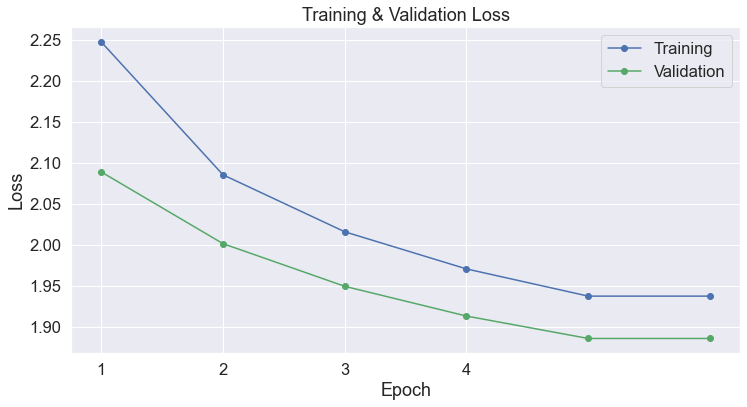

In [23]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

image_name = osp.join(model_save_dir, "Training_Loss.png")
plt.savefig(image_name)

plt.show()

# Display Model Info

In [21]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 76 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072,

# Saving & Loading Fine-Tuned Model


In [19]:
print(f"Saving model to {model_save_dir}")

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # remove distributed/parallel training if necessary
model_to_save.save_pretrained(model_save_dir)
tokenizer.save_pretrained(model_save_dir)

Saving model to ./model_save/20221228_2153


('./model_save/20221228_2153\\tokenizer_config.json',
 './model_save/20221228_2153\\special_tokens_map.json',
 './model_save/20221228_2153\\vocab.json',
 './model_save/20221228_2153\\merges.txt',
 './model_save/20221228_2153\\added_tokens.json',
 './model_save/20221228_2153\\tokenizer.json')

In [25]:
# Load a fine-tuned model
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

# Generate Text

In [26]:
model.eval()

prompt = "cindy manilow was"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=10, 
                                max_length = 50,
                                top_p=0.97, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[ 66, 521,  88, 582, 346, 322, 373]], device='cuda:0')
0: cindy manilow was the band that made me a fan, i would always have to hear him in the studio, so i did. his voice is very strong, and his music is a lot more than the songs that come in the


1: cindy manilow was not the best album he had ever done,but he was good as hell.he was better in this album then the other one but this one was better too.


2: cindy manilow was a very talented guitarist, but this album was not as good as i expected.  The songs are very different and the lyrics are very similar to those of the past.  This was the first of the three songs


3: cindy manilow was an awesome band, but they had been known for being very talented, i was not sure what to expect, i really wanted to see what they were like, but they were a great band. They had a great


4: cindy manilow was a huge hit from the 80's, but this CD is so much fun, and has great songs. heres the song-by-song-by-song:

Lights:

1.


